# Filter Bank Common Spatial Pattern
Attempt at implementing filter-bank common spatial filter (FBCSP) on BCI Competition IV 2a Dataset
  
**References:**   

[1] Kai Keng Ang, Zheng Yang Chin, Haihong Zhang and Cuntai Guan, "Filter Bank Common Spatial Pattern (FBCSP) in Brain-Computer Interface," 2008 IEEE International Joint Conference on Neural Networks (IEEE World Congress on Computational Intelligence), Hong Kong, 2008, pp. 2390-2397, doi: 10.1109/IJCNN.2008.4634130.    
[2] Ang, K. K., Chin, Z. Y., Wang, C., Guan, C., & Zhang, H. (2012). Filter Bank Common Spatial Pattern Algorithm on BCI Competition IV Datasets 2a and 2b. Frontiers in Neuroscience, 6. doi: 10.3389/fnins.2012.00039

# BCI Competition IV Dataset 2a (.npz data)
Information Given in Documentation

From the documentation it is known that:
* 25 electrodes are used, first 22 are EEG, last 3 are EOG
* Sampling frequency (fs) is 250Hz
* 9 subjects
* 9 run (run 1-3 are for eye movement, run 4-9 is MI)  
  

**-- Time Duration--**  
1 trials                          = 7-8s  
1 run              = 48 trials    = 336-384s  
1 session = 6 runs = 288 trials   = 2016-2304s

About the recording of eye movement
* run 1 => 2 mins with eyes open
* run 2 => 1 min with eyes closed
* run 3 => 1 min with eye movements

![timing-scheme-paradigm.png](./img/timing-scheme-paradigm.png) 

# Nathan Dayie Documentation

Last Updated: 4/2/2025

The original notebook only classified the training dataset into the left hand and right hand classes. It did so by splitting the training dataset (denoted as AOXT.npz files) 80/20, 80% used to train a classic ML model and 20% used to test the model. Eventually, we want to use 100% of the training dataset to train a deep learning model and see if it can better classify this dataset than the classical models. This final goal will be approached in steps, step 0 of which has already been completed by working through this original notebook.

#### Step 0 (complete as of 2/11/25) - Apply classical ML model to classify BCI Comp IV Dataset 2a (training data) into left hand and right hand classes.

##### Modifications to notebook:
- the original notebook only looked at subject's 1-3, but I modified it to classify all 9 subjects
- this mostly just meant adjusting for loops that went in range(1,4) to range(1,ns) where ns = 10, 1 more than the number of subjects there were in the data set

##### NOTE: (created 4/2/2025)
- this notebook is a copy of the fbcsp.ipynb document being edited. This copy is here to maintain the Step 0 version of the code. We wanted this to test out certain things on only the 2-class classification between left (class 1) and right (class 2) w/o including the feet (class 3) and tongue (class 4) classes.

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Loading dataset

In [67]:
# First import the data

# Number of subject, n + 1 for iteration purpose (there are 9 subjects)
ns = 10

# Creating dict to store original data and modified data
ori_data = dict() # ori_data will serve as initial loaded data that will remain unchanged
mod_data = dict() # mod_data will contain modified original data

# # Step 2 Modification
# eval_data = dict() # eval_data will contain the original evaluation data
# mod_eval_data = dict() # mod_eval_data will contain modified evaluation data

In [68]:
# Function to count subject
def subject_counter(i):
    return 'subject0{}'.format(i)

In [69]:
# Path manipulation if running in dev container
if os.getcwd() == '/':
    print("Running the notebook it inside dev container..")
    base_dir = os.environ["DOCKER_WORKDIR"]
else:
    print("Running the notebook locally..")
    base_dir = os.getcwd()

Running the notebook locally..


In [70]:
# Load the training data of all subjects

# Iter over all data path then store them in sub0X variable
for i in range(1, ns):
    data_path = os.path.join('A{:02d}T.npz'.format(i))
    eval_data_path = os.path.join('A{:02d}E.npz'.format(i))
    subject = 'subject{:02d}'.format(i)
    
    # Load EEG data from datapath and store into subj0X variable then store into data dictionary
    ori_data[subject] = np.load(data_path)
    # eval_data[subject] = np.load(eval_data_path) # Step 2 modification

In [6]:
# Peek into ori_data type and its keys 
print(type(ori_data['subject01']))
# print(type(ori_data['subject01']['s']))
print(ori_data['subject01'].files) # can replace 01 with 01-09 for subject0X key, and will get same output
# the type of each value behind each key ['s', 'etyp', 'epos', 'edur', 'artifacts'] is a numpy.ndarray

<class 'numpy.lib.npyio.NpzFile'>
['s', 'etyp', 'epos', 'edur', 'artifacts']


In [7]:
# peak at data inside of ori_data['subject01']['artifacts'] using ravel
# numpy.ndarray.ravel() flattens an m x n array into a 1 x mn array and displays it
ori_data['subject01']['artifacts'].ravel()[20:50]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)

Explanation regarding contents of the keys inside each subject data:
* **s**: 's' contains continuous time-series recorded EEG signals are, shape of M x N array. Size may vary between subjects but N is fixed to 25, indicates 25 electrodes with 22 first EEG and 3 last EOG
* **etype**: 'etyp' stands for event type which indicate event occurence, event code will be describe in subsequent table
* **epos**: 'epos' stands for event position, denoting corresponding event begins at n-th sample at **'s'**
* **edur**: 'edur' stands for event duration, denoting duration of corresponding event
* **artifacts**: size of 288 x 1, 288 comes form 6 x 48, 6 runs where @run has 48 trials, @class has 12 trials

In [71]:
# ori_data will contain original data that is the raw file
# mod_data will contain modified original data

# Initialize 'subject0x' dict inside mod_data
for i in range(1, ns):
    subj = subject_counter(i)
    mod_data[subj] = {}

In [72]:
# Peek into different shape of recorded data/'s' between subjects
print('Sample\tElectrodes')
for i in range(1, ns):
    subj_temp = subject_counter(i)
    print(f"{subj_temp}\t{ori_data[subj_temp]['s'].shape}")


Sample	Electrodes
subject01	(672528, 25)
subject02	(677169, 25)
subject03	(660530, 25)
subject04	(600915, 25)
subject05	(686120, 25)
subject06	(678980, 25)
subject07	(681071, 25)
subject08	(675270, 25)
subject09	(673328, 25)


In [73]:
# First extract the sample data from ori_data into mod_data
for i in range(1, ns):
    subj = subject_counter(i)
    mod_data[subj]['raw_EEG'] = ori_data[subj]['s']

In [11]:
# Visualizing sample_data inside subject01
# You can see that it has 25 electrodes stored in columns
pd.DataFrame(mod_data['subject01']['raw_EEG']).head() 

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-21.142578,-23.681641,-21.484375,-25.146484,-25.732422,-27.929688,-14.550781,-22.509766,-25.439453,-28.710938,...,-30.615234,-29.638672,-26.660156,-20.947266,-25.439453,-24.902344,-19.677734,31.738281,-13.671875,-43.945312
1,-21.923828,-23.925781,-24.316406,-25.341797,-26.074219,-25.244141,-16.064453,-22.753906,-28.320312,-29.248047,...,-31.054688,-30.712891,-26.123047,-22.998047,-27.099609,-26.367188,-23.339844,22.460938,-13.183594,-40.527344
2,-15.625000,-19.726562,-18.847656,-21.582031,-20.751953,-21.728516,-12.451172,-20.410156,-23.730469,-25.927734,...,-28.759766,-28.417969,-24.462891,-21.386719,-25.097656,-24.267578,-21.484375,33.691406,-8.300781,-38.574219
3,-16.699219,-13.720703,-20.361328,-20.849609,-24.169922,-22.021484,-10.986328,-16.357422,-25.585938,-24.951172,...,-27.783203,-28.857422,-25.537109,-19.335938,-24.316406,-24.511719,-17.919922,41.992188,-7.324219,-38.574219
4,-19.335938,-17.626953,-20.410156,-26.464844,-27.392578,-29.882812,-9.277344,-18.359375,-24.609375,-30.517578,...,-31.884766,-33.740234,-32.666016,-18.554688,-26.611328,-28.466797,-18.408203,37.109375,-15.136719,-49.804688


# Preprocessing

In [74]:
# Removing last three EOG electrode using np.delete, store data as EEG_only to each subject dict
for i in range(1, ns):
    subj = subject_counter(i)
    mod_data[subj]['raw_EEG'] = np.delete(mod_data[subj]['raw_EEG'], np.s_[22:], 1)
    # mod_eval_data[subj]['raw_EEG'] = np.delete(mod_eval_data[subj]['raw_EEG'], np.s_[22:], 1) # Step 2 Modification

## Bandpass Filtering
The first stage employing a filter bank is to decompose EEG into multiple frequency pass band, using causal Chebysev Type II filter/ Butterworth Filter.  
A total of 9 band-pass filters are used, namely, 4-8, 8-12, ... 36-40 Hz  
These frequency ranges are used because they yielf a stable frequency response and cover range of 4-40 Hz

In [75]:
# Band pass filter with butterworth filter
from scipy.signal import butter, lfilter
from scipy.signal import freqz

In [76]:

def butter_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut/nyq
    high = highcut/nyq
    b,a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, signal, axis=-1)
    
    return y

### Practice
Create arbitrary signal and using butterworth signal as band-pass filter

In [15]:
# # INPUT
# # sampling frequency
# fs = 500

# # time
# t = np.arange(0, 5, 1/fs)

# # Three signals with various freq
# x1 = np.sin(2 * np.pi * 6 * t)
# x2 = np.sin(2 * np.pi * 7 * t)
# x3 = np.sin(2 * np.pi * 50 * t)
# x = x1 + x2 + x3

In [16]:
# # Plot input
# plt.figure(figsize=(5, 3), dpi=80)
# plt.clf()
# plt.plot(t, x)
# plt.xlabel('time (seconds)')
# plt.show()

In [17]:
# # OUTPUT
# lowcut = 4
# highcut = 8
# y= butter_bandpass_filter(x, lowcut, highcut, fs, order=5)

In [18]:
# # Plot output
# plt.figure(figsize=(5, 3), dpi=80)
# plt.clf()
# plt.plot(t, y, label='Filtered signal (%g Hz)' %fs)
# plt.xlabel('time (seconds)')
# plt.grid(True)
# plt.show()

In [19]:
# # OUTPUT
# lowcut = 36
# highcut = 40
# y= butter_bandpass_filter(x, lowcut, highcut, fs, order=5)

In [20]:
# # Plot output
# plt.figure(figsize=(5, 3), dpi=80)
# plt.clf()
# plt.plot(t, y, label='Filtered signal (%g Hz)' %fs)
# plt.xlabel('time (seconds)')
# plt.grid(True)
# plt.show()

### Filtering EEG signal with Butterworth Band-pass
Following the steps mentioned in [1], there will be 8 band-pass filter with bandwidth of:
1. 4-8Hz
2. 8-12Hz
3. 12-16Hz
4. 16-20Hz
5. 20-24Hz
6. 24-28Hz
7. 28-32Hz
8. 32-36Hz
9. 36-40Hz

*Note*   
Apply filter to the time-series axis, thus set 'raw_EEG' inside each subject to shape of N x T (i.e. electrodes x samples)

In [77]:
# Transpose all 'raw_EEG' data
for i in range(1, ns):
    subj = subject_counter(i)
    
    while mod_data[subj]['raw_EEG'].shape[0] != 22:
        mod_data[subj]['raw_EEG'] = mod_data[subj]['raw_EEG'].T
        # mod_eval_data[subj]['raw_EEG'] = mod_eval_data[subj]['raw_EEG'].T # Step 2 Modification
    
    print(f"Train: {subj}\t{mod_data[subj]['raw_EEG'].shape}")
    # print(f"Eval: {subj}\t{mod_eval_data[subj]['raw_EEG'].shape}") # Step 2 Modification

Test: subject01	(22, 672528)
Test: subject02	(22, 677169)
Test: subject03	(22, 660530)
Test: subject04	(22, 600915)
Test: subject05	(22, 686120)
Test: subject06	(22, 678980)
Test: subject07	(22, 681071)
Test: subject08	(22, 675270)
Test: subject09	(22, 673328)


In [78]:
# Create function that could bandpass filtered one subject
def butter_bandpass_one_subject(data, subj, lowcut, highcut, fs, interval=None):

    # STORE DATA LOCALLY RATHER THAN IN RAM (RAM updates)
    os.makedirs("./preprocessed", exist_ok=True) # RAM updates
    
    print('Processing ', subj)
    
    # Create new key 'EEG_filtered' to store filtered EEG of each subject
    data[subj]['EEG_filtered'] = {}
    
    # Current raw EEG
    temp_raw_EEG = data[subj]['raw_EEG']
    print(f"{subj}: {temp_raw_EEG.shape}")
    
    if interval is not None:
        startband = np.arange(lowcut, highcut, step = interval)
        
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start+interval)
            
            print('Filtering through {} Hz band'.format(band))

            # Save Memory Changes  vvv
            filtered_EEG = butter_bandpass_filter(temp_raw_EEG, start, start+interval, fs) # temp var to hold filtered data

            save_path = f"./preprocessed/{subj}_{band}_filtered.npz" # pathway to save current preprocessed band
            np.savez_compressed(save_path, EEG=filtered_EEG) # save processed band to pathway defined above
            data[subj]['EEG_filtered'][band] = {}
            data[subj]['EEG_filtered'][band]['file_path'] = save_path # store saved path in dictionary
            
            del filtered_EEG  # free memory to help later cells (can comment out)

            # Save Memory Changes  ^^^

            # # Bandpass filtering
            # data[subj]['EEG_filtered'][band]['EEG_all'] = butter_bandpass_filter(temp_raw_EEG, start, start+interval, fs)
            # print(f"{subj}_{band}\t{data[subj]['EEG_filtered'][band]['EEG_all'].shape}")
    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        # Save Memory Changes  vvv
        filtered_EEG = butter_bandpass_filter(temp_raw_EEG, lowcut, highcut, fs) # temp var to hold filtered data

        save_path = f"./preprocessed/{subj}_{band}_filtered.npz" # pathway to save current preprocessed band
        np.savez_compressed(save_path, EEG=filtered_EEG) # save processed band to pathway defined above
        data[subj]['EEG_filtered'][band]['file_path'] = save_path # store saved path in dictionary
        
        del filtered_EEG  # free memory to help later cells (can comment out)

        # Save Memory Changes  ^^^

        # data[subj]['EEG_filtered'][band]['EEG_all'] = butter_bandpass_filter(temp_raw_EEG, lowcut, highcut, fs)


In [79]:
# Bandpass filtering all subject 
lowcut=4
highcut=40
fs = 250
ns = 10

# Iterate over all subjects
for i in range(8, ns):
    subj = subject_counter(i)
    butter_bandpass_one_subject(mod_data, subj, lowcut, highcut, fs, interval=4)
    # print('')

Processing  subject08
subject08: (22, 675270)
Filtering through 04_08 Hz band
Filtering through 08_12 Hz band
Filtering through 12_16 Hz band
Filtering through 16_20 Hz band
Filtering through 20_24 Hz band
Filtering through 24_28 Hz band
Filtering through 28_32 Hz band


KeyboardInterrupt: 

## Taking EEG data corresponds to left and right class (now all 4 classes)
This work will only clasify two class, left and right hand, meanwhile the data contains four class,  
thus the goal here is to make band-filtered EEG left and right of each class of shape T x C x N, where  
T = trial, C = channel, N = sample

### Step 1 modification:
This work will now classify all four classes, left hand, right hand, feet, and tongue.

In [2]:
# First take the position of left and right class
left_class_code = 769
right_class_code = 770

# # Step 1 Modification:
# # Take the position of both feet (class 3) and tongue (class 4) classes
# feet_class_code = 771
# tongue_class_code = 772

for i in range(1, ns): # replaced 4 with ns (step 0)
    subj = subject_counter(i)
    
    mod_data[subj]['left_pos'] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == left_class_code]
    mod_data[subj]['right_pos'] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == right_class_code]
    
    # # step 1 modifications:
    # mod_data[subj]['feet_pos'] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == feet_class_code]
    # mod_data[subj]['tongue_pos'] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == tongue_class_code]

    # # step 2 modifications:
    # mod_eval_data[subj]['left_pos'] = eval_data[subj]['epos'][eval_data[subj]['etyp'] == left_class_code]
    # mod_eval_data[subj]['right_pos'] = eval_data[subj]['epos'][eval_data[subj]['etyp'] == right_class_code]
    # mod_eval_data[subj]['feet_pos'] = eval_data[subj]['epos'][eval_data[subj]['etyp'] == feet_class_code]
    # mod_eval_data[subj]['tongue_pos'] = eval_data[subj]['epos'][eval_data[subj]['etyp'] == tongue_class_code]

NameError: name 'ns' is not defined

In [6]:
# Rebuild mod_data from saved, preprocessed .npz files:

# 👇 REBUILD `mod_data` STRUCTURE FROM SAVED FILES 👇

import os
import numpy as np

mod_data = {}
ori_data = {}

bands = ["{:02d}_{:02d}".format(i, i+4) for i in range(4, 40, 4)]
ns = 10
fs = 250  # Sampling frequency

# Rebuild from saved filtered .npz files and raw .npz files
for i in range(1, ns):
    subj = subject_counter(i)
    mod_data[subj] = {}
    mod_data[subj]['EEG_filtered'] = {}

    # Load raw EEG metadata to extract event positions
    ori_data[subj] = np.load(f"A{i:02d}T.npz")
    mod_data[subj]['left_pos'] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == 769]
    mod_data[subj]['right_pos'] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == 770]

    for band in bands:
        path = f"./preprocessed/{subj}_{band}_filtered.npz"
        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing preprocessed file: {path}")
        mod_data[subj]['EEG_filtered'][band] = {
            'file_path': path
        }

print("✅ mod_data rebuilt successfully from saved files.")


✅ mod_data rebuilt successfully from saved files.


In [6]:
# IDENTIFY CORRUPTED PREPROCSSED FILES

from pathlib import Path

print("🔍 Checking .npz files for corruption...\n")

for i in range(1, 10):
    subj = subject_counter(i)
    for band in mod_data[subj]['EEG_filtered'].keys():
        path = Path(mod_data[subj]['EEG_filtered'][band]['file_path'])
        try:
            if not path.exists():
                print(f"❌ MISSING: {path}")
            elif path.stat().st_size == 0:
                print(f"❌ EMPTY: {path}")
            else:
                _ = np.load(path)['EEG']  # Try loading to catch corruption
        except Exception as e:
            print(f"❌ CORRUPTED: {path} -> {e}")


🔍 Checking .npz files for corruption...



In [22]:
# FIX SPECIFIC, CORRUPTED, .NPZ PREPROCESSED BAND

subj = "subject09"
band_start = 36
band_end = 40
fs = 250

raw_EEG = np.delete(np.load("A09T.npz")['s'], np.s_[22:], 1)

# Ensure it has shape (22, N)
if raw_EEG.shape[0] != 22:
    raw_EEG = raw_EEG.T

from scipy.signal import butter, lfilter

def butter_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, signal, axis=-1)

filtered = butter_bandpass_filter(raw_EEG, band_start, band_end, fs)

# Save to disk
save_path = f"./preprocessed/{subj}_{band_start:02d}_{band_end:02d}_filtered.npz"
np.savez_compressed(save_path, EEG=filtered)

print(f"✅ Recreated and saved {save_path}")


✅ Recreated and saved ./preprocessed/subject09_36_40_filtered.npz


In [7]:
# Now take EEG data within [0.5 3.5] seconds after cue onset position of each class
start = 0.5
end = 3.5
ns = 10

# Please modify this range to add more subject
for i in range(1, ns):
    subj = subject_counter(i)
    print('Processing ', subj)
    # Temporary variable of left and right pos    
    temp_pos_left = mod_data[subj]['left_pos']
    temp_pos_right = mod_data[subj]['right_pos']

    # Temporary variable of feet and tongue pos    
    # temp_pos_feet = mod_data[subj]['feet_pos'] # step 1 modification
    # temp_pos_tongue = mod_data[subj]['tongue_pos'] # step 1 modification
 
    for band in mod_data[subj]['EEG_filtered'].keys():
        temp_EEG_all = np.load(mod_data[subj]['EEG_filtered'][band]['file_path'])['EEG'] # memory saving change
        temp_EEG_left = []
        temp_EEG_right = []
        # temp_EEG_feet = [] # step 1 modification
        # temp_EEG_tongue = [] # step 1 modification
        
        # LEFT
        for j in range(len(temp_pos_left)):
            temp_EEG_left.append(temp_EEG_all[:, temp_pos_left[j] + int(start*fs) : temp_pos_left[j] + int(end*fs)])
        mod_data[subj]['EEG_filtered'][band]['EEG_left'] = np.array(temp_EEG_left)
        
        # RIGHT
        for j in range(len(temp_pos_right)):
            temp_EEG_right.append(temp_EEG_all[:, temp_pos_right[j] + int(start*fs) : temp_pos_right[j] + int(end*fs)])
        mod_data[subj]['EEG_filtered'][band]['EEG_right'] = np.array(temp_EEG_right)

        # # step 1 modifications

        #  # FEET
        # for j in range(len(temp_pos_feet)):
        #     temp_EEG_feet.append(temp_EEG_all[:, temp_pos_feet[j] + int(start*fs) : temp_pos_feet[j] + int(end*fs)])
        # mod_data[subj]['EEG_filtered'][band]['EEG_feet'] = np.array(temp_EEG_feet)
        
        # # TONGUE
        # for j in range(len(temp_pos_tongue)):
        #     temp_EEG_tongue.append(temp_EEG_all[:, temp_pos_tongue[j] + int(start*fs) : temp_pos_tongue[j] + int(end*fs)])
        # mod_data[subj]['EEG_filtered'][band]['EEG_tongue'] = np.array(temp_EEG_tongue)

Processing  subject01
Processing  subject02
Processing  subject03
Processing  subject04
Processing  subject05
Processing  subject06
Processing  subject07
Processing  subject08
Processing  subject09


# Train/Test Data Split

In [8]:
def split_EEG_one_class(EEG_one_class, percent_train=0.8):
    '''
    split_EEG_one_class will receive EEG data of one class, with size of T x N x M, where
    T = number of trial
    N = number of electrodes
    M = sample number
    
    INPUT:
    EEG_data_one_class: the data of one class of EEG data
    
    percent_train: allocation percentage of training data, default is 0.8
    
    OUTPUT:
    EEG_train: EEG data for training
    
    EEG_test: EEG data for test
    
    Both have type of np.arrray dimension of T x M x N
    '''

    # Number of all trials
    n = EEG_one_class.shape[0]
    
    n_tr = round(n*percent_train)
    n_te = n - n_tr
    
    EEG_train = EEG_one_class[:n_tr]
    EEG_test = EEG_one_class[n_tr:n_tr+n_te]
        
    return EEG_train, EEG_test

In [9]:
# Iterate over all subjects
for i in range(1, ns):
    
    subj = subject_counter(i)
    
    # Iterate over all bands
    for band in mod_data[subj]['EEG_filtered'].keys():
        
        # Temporary variable for left and right class of each band
        temp_EEG_left = mod_data[subj]['EEG_filtered'][band]['EEG_left']
        temp_EEG_right = mod_data[subj]['EEG_filtered'][band]['EEG_right']

        # # step 1 modifications
        # # Temporary variable for feet and tongue class of each band
        # temp_EEG_feet = mod_data[subj]['EEG_filtered'][band]['EEG_feet'] # step 1 addition
        # temp_EEG_tongue = mod_data[subj]['EEG_filtered'][band]['EEG_tongue'] # step 1 addition

        # Temporary variable to access each band
        temp_filt = mod_data[subj]['EEG_filtered'][band]
        
        temp_filt['EEG_left_train'], temp_filt['EEG_left_test'] = split_EEG_one_class(temp_EEG_left, 0.8)
        temp_filt['EEG_right_train'], temp_filt['EEG_right_test'] = split_EEG_one_class(temp_EEG_right, 0.8)  
        
        # # step 1 modifications:
        # temp_filt['EEG_feet_train'], temp_filt['EEG_feet_test'] = split_EEG_one_class(temp_EEG_feet, 0.8) # step 1 addition
        # temp_filt['EEG_tongue_train'], temp_filt['EEG_tongue_test'] = split_EEG_one_class(temp_EEG_tongue, 0.8) # step 1 addition

In [10]:
mod_data['subject01']['EEG_filtered']['04_08'].keys()

dict_keys(['file_path', 'EEG_left', 'EEG_right', 'EEG_left_train', 'EEG_left_test', 'EEG_right_train', 'EEG_right_test'])

# CSP
This step will perform CSP on each band of each subject

In [11]:
# For all subject create new keys to store all result in CSP step
for i in range(1, ns):
    subj = subject_counter(i)
    
    mod_data[subj]['CSP'] = {}

## Covariance and Composite Covariance

In [12]:
def compute_cov(EEG_data):
    '''
    INPUT:
    EEG_data : EEG_data in shape T x N x S
    
    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    '''
    cov = []
    for i in range(EEG_data.shape[0]):
        cov.append(EEG_data[i]@EEG_data[i].T/np.trace(EEG_data[i]@EEG_data[i].T))
        
    cov = np.mean(np.array(cov), 0)
    
    return cov

In [13]:
# Iterate over all subjects
for i in range(1, ns):
    
    subj = subject_counter(i)
    
    # Iterate over all bands
    for band in mod_data[subj]['EEG_filtered'].keys():
        
        # New key to store result
        temp_band = mod_data[subj]['CSP'][band] = {}
        
        # Compute left and right covariance
        # LEFT
        temp_band['cov_left'] = compute_cov(mod_data[subj]['EEG_filtered'][band]['EEG_left_train'])
        
        # RIGHT
        temp_band['cov_right'] = compute_cov(mod_data[subj]['EEG_filtered'][band]['EEG_right_train'])

        # # Step 1 Modifications: compute feet and tongue covariance
        # # FEET
        # temp_band['cov_feet'] = compute_cov(mod_data[subj]['EEG_filtered'][band]['EEG_feet_train']) # step 1 addition
        
        # # TONGUE
        # temp_band['cov_tongue'] = compute_cov(mod_data[subj]['EEG_filtered'][band]['EEG_tongue_train']) # step 1 addition


        
        # Add covariance of left and right class as composite covariance
        # temp_band['cov_comp'] = temp_band['cov_left'] + temp_band['cov_right'] + temp_band["cov_feet"] + temp_band["cov_tongue"] # last 2 step 1 addition
        temp_band['cov_comp'] = temp_band['cov_left'] + temp_band['cov_right']

In [14]:
# temp1 = mod_data['subject03']['CSP']['04_08']['cov_left']
# temp2 = mod_data['subject03']['CSP']['04_08']['cov_right']
# temp3 = mod_data['subject03']['CSP']['04_08']['cov_comp']

## White Matrix (P)

In [15]:
# Create new keys for result in whitening step
for i in range(1, ns):
    subj = subject_counter(i)
    
    for band in mod_data[subj]['EEG_filtered'].keys():
        mod_data[subj]['CSP'][band]['whitening'] = {}

In [16]:
from scipy.linalg import sqrtm
from scipy.linalg import inv

In [17]:
def decompose_cov(avg_cov):
    '''
    This function will decompose average covariance matrix of one class of each subject into 
    eigenvalues denoted by lambda and eigenvector denoted by V
    Both will be in descending order
    
    Parameter:
    avgCov = the averaged covariance of one class
    
    Return:
    λ_dsc and V_dsc, i.e. eigenvalues and eigenvector in descending order
    
    '''
    λ, V = np.linalg.eig(avg_cov)
    λ_dsc = np.sort(λ)[::-1] # Sort eigenvalue descending order, default is ascending order sort
    idx_dsc = np.argsort(λ)[::-1] # Find index in descending order
    V_dsc = V[:, idx_dsc] # Sort eigenvectors descending order
    λ_dsc = np.diag(λ_dsc) # Diagonalize λ_dsc
    
    return λ_dsc, V_dsc

In [18]:
def white_matrix(λ_dsc, V_dsc):
    '''
    '''
    λ_dsc_sqr = sqrtm(inv(λ_dsc))
    P = (λ_dsc_sqr)@(V_dsc.T)
    
    return P

In [19]:
# Iterate over all subject compute whitening matrix
for i in range(1, ns):
    subj = subject_counter(i)
    
    for band in mod_data[subj]['EEG_filtered'].keys():
        
        temp_whitening = mod_data[subj]['CSP'][band]['whitening']

        temp_cov = mod_data[subj]['CSP'][band]['cov_comp']

        # Decomposing composite covariance into eigenvector and eigenvalue
        temp_whitening['eigval'], temp_whitening['eigvec'] = decompose_cov(temp_cov)

        # White matrix
        temp_whitening['P'] = white_matrix(temp_whitening['eigval'], temp_whitening['eigvec'])

## Common Eigenvec from Sl and Sr
In this step the Sl and Sr will not be stored, will only be used to compute each eigenvector

In [20]:
# Create new keys for result in whitening step
for i in range(1, ns):
    subj = subject_counter(i)
    
    for band in mod_data[subj]['EEG_filtered'].keys():
        mod_data[subj]['CSP'][band]['S_left'] = {}
        mod_data[subj]['CSP'][band]['S_right'] = {}  
        # mod_data[subj]['CSP'][band]['S_feet'] = {} # step 1 addition
        # mod_data[subj]['CSP'][band]['S_tongue'] = {} # step 1 addition

In [21]:
def compute_S(avg_Cov, white):
    '''
    This function will compute S matrix, S = P * C * P.T

    INPUT:
    avg_Cov: averaged covariance of one class, dimension N x N, where N is number of electrodes
    white: the whitening transformation matrix
    
    OUTPUT:
    S
    '''
    S = white@avg_Cov@white.T
    
    return S

In [22]:
def decompose_S(S_one_class, order='descending'):
    '''
    This function will decompose the S matrix of one class to get the eigen vector
    Both eigenvector will be the same but in opposite order
    
    i.e the highest eigenvector in S left will be equal to lowest eigenvector in S right matrix 
    '''
    # Decompose S
    λ, B = np.linalg.eig(S_one_class)
    
    # Sort eigenvalues either descending or ascending
    if order == 'ascending':
        idx = λ.argsort() # Use this index to sort eigenvector smallest -> largest
    elif order == 'descending':
        idx = λ.argsort()[::-1] # Use this index to sort eigenvector largest -> smallest
    else:
        print('Wrong order input')
    
    λ = λ[idx]
    B = B[:, idx]
    
    return B, λ 

In [23]:
# Iterate over all subjects
for i in range(1, ns):
    subj = subject_counter(i)
    
    for band in mod_data[subj]['EEG_filtered'].keys():
        # Where to access data
        temp_P = mod_data[subj]['CSP'][band]['whitening']['P']
        Cl = mod_data[subj]['CSP'][band]['cov_left']
        Cr = mod_data[subj]['CSP'][band]['cov_right']
        # Cf = mod_data[subj]['CSP'][band]['cov_feet'] # step 1 addition
        # Ct = mod_data[subj]['CSP'][band]['cov_tongue'] # step 1 addition

        # Where to store result
        # print(f"Band: {band}\tKeys: {mod_data[subj]['CSP'][band].keys()}") # used for debugging on key error
        temp_Sl = mod_data[subj]['CSP'][band]['S_left']
        temp_Sr = mod_data[subj]['CSP'][band]['S_right']
        # temp_Sf = mod_data[subj]['CSP'][band]['S_feet'] # step 1 addition
        # temp_St = mod_data[subj]['CSP'][band]['S_tongue'] # step 1 addition

        # LEFT
        Sl = compute_S(Cl, temp_P)
        temp_Sl['eigvec'], temp_Sl['eigval'] = decompose_S(Sl, 'descending')

        # RIGHT
        Sr = compute_S(Cr, temp_P)
        temp_Sr['eigvec'], temp_Sr['eigval'] = decompose_S(Sr, 'ascending')   

        # # step 1 addition; add calculations for feet and tongue classes as well

        # # FEET
        # Sf = compute_S(Cf, temp_P)
        # temp_Sf['eigvec'], temp_Sf['eigval'] = decompose_S(Sf, 'descending')

        # # TONGUE
        # St = compute_S(Ct, temp_P)
        # temp_St['eigvec'], temp_St['eigval'] = decompose_S(St, 'ascending')   

In [24]:
# Checking eigenvalues
# temp1 = mod_data['subject02']['CSP'][band]['S_left']['eigval']
# temp2 = mod_data['subject02']['CSP'][band]['S_right']['eigval']
# temp3 = mod_data['subject02']['CSP'][band]['S_feet']['eigval']
# temp4 = mod_data['subject02']['CSP'][band]['S_tongue']['eigval']

In [25]:
# temp1 + temp2 

## Spatial Filter (W)
Will compute the spatial filter of each subject of each band

In [26]:
def spatial_filter(B, P):
    '''
    Will compute projection matrix using the following equation:
    W = B' @ P
    
    INPUT:
    B: the eigenvector either left or right class, choose one, size N x N, N is number of electrodes
    P: white matrix in size of N x N 
    
    OUTPUT:
    W spatial filter to filter EEG
    '''
    
    return (B.T@P)

In [27]:
# Iterate over all subject
for i in range(1, ns):
    subj = subject_counter(i)
    
    for band in mod_data[subj]['EEG_filtered'].keys():
        temp_eigvec = mod_data[subj]['CSP'][band]['S_left']['eigvec']
        temp_P = mod_data[subj]['CSP'][band]['whitening']['P']

        mod_data[subj]['CSP'][band]['W'] = spatial_filter(temp_eigvec, temp_P)

In [28]:
temp = mod_data['subject01']['CSP'][band]['W']

In [29]:
pd.DataFrame(temp).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-2.067070,-1.795517,0.674657,-0.600279,-0.531707,0.051805,-3.608875,13.728214,2.541841,-10.669084,...,-0.425582,-2.234119,-5.843472,-1.293616,10.676630,-10.946518,5.049042,-13.617284,8.553094,1.837880
1,3.211127,3.787021,2.845078,-10.448529,5.912025,4.520385,-0.201067,-3.131450,2.107775,3.001354,...,0.554703,-4.511234,-3.368763,9.981609,-0.044676,1.422170,6.427704,-6.862532,-3.545508,2.428964
2,0.552975,-2.063569,8.071851,-6.107381,-4.715290,-1.655538,0.547787,2.839704,-4.037424,-0.650903,...,-1.897266,-5.762726,3.309403,7.634191,-16.817554,9.931688,1.589882,-2.605074,-5.322589,3.264397
3,0.916960,3.301811,-1.701912,-7.291251,8.600569,-1.170277,4.354018,-4.512817,-8.844287,11.326760,...,-3.514433,-1.926884,8.258898,-7.649393,5.699625,7.526022,4.220684,0.045373,-3.332243,-2.371642
4,4.530817,-4.483058,0.696202,-1.169662,-9.148162,1.393574,-1.243655,7.320754,-6.916603,12.311359,...,2.384958,-3.037356,13.978873,-14.547555,7.692809,-3.559007,-2.550236,-0.107876,-6.187102,4.079949


# Feature Vector Train

In [30]:
# Create new keys for training and test feature vector
for i in range(1, ns):
    subj = subject_counter(i)
    mod_data[subj]['train'] = {}
    mod_data[subj]['test'] = {}
    
    for band in mod_data[subj]['EEG_filtered'].keys():
        mod_data[subj]['train'][band] = {}
        mod_data[subj]['test'][band] = {}       

In [31]:
# Select number of filter
m = 2

In [32]:
def compute_Z(W, E, m):
    '''
    Will compute the Z
    Z = W @ E, 
    
    E is in the shape of N x M, N is number of electrodes, M is sample
    In application, E has nth trial, so there will be n numbers of Z
    
    Z, in each trial will have dimension of m x M, 
    where m is the first and last m rows of W, corresponds to smallest and largest eigenvalues
    '''
    Z = []
    
    W = np.delete(W, np.s_[m:-m:], 0)
    
    for i in range(E.shape[0]):
        Z.append(W @ E[i])
    
    return np.array(Z)

In [33]:
def feat_vector(Z):
    '''
    Will compute the feature vector of Z matrix
    
    INPUT:
    Z : projected EEG shape of T x N x S
    
    OUTPUT:
    feat : feature vector shape of T x m
    
    T = trial
    N = channel
    S = sample
    m = number of filter
    '''
    
    feat = []
    
    for i in range(Z.shape[0]):
        var = np.var(Z[i], ddof=1, axis=1)
        varsum = np.sum(var)
        
        feat.append(np.log10(var/varsum))
        
    return np.array(feat)

In [34]:
mod_data['subject01']['CSP']['04_08'].keys()

dict_keys(['cov_left', 'cov_right', 'cov_comp', 'whitening', 'S_left', 'S_right', 'W'])

In [35]:
mod_data['subject01']['EEG_filtered'][band].keys()

dict_keys(['file_path', 'EEG_left', 'EEG_right', 'EEG_left_train', 'EEG_left_test', 'EEG_right_train', 'EEG_right_test'])

In [36]:
# Iterate over all subjects
for i in range(1, ns):
    subj = subject_counter(i)
    
    for band in mod_data[subj]['EEG_filtered'].keys():
        temp_W = mod_data[subj]['CSP'][band]['W']
        temp_EEG_left = mod_data[subj]['EEG_filtered'][band]['EEG_left_train']
        temp_EEG_right = mod_data[subj]['EEG_filtered'][band]['EEG_right_train']
        # temp_EEG_feet = mod_data[subj]['EEG_filtered'][band]['EEG_feet_train'] # step 1 addition
        # temp_EEG_tongue = mod_data[subj]['EEG_filtered'][band]['EEG_tongue_train'] # step 1 addition

        # LEFT
        mod_data[subj]['train'][band]['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
        mod_data[subj]['train'][band]['feat_left'] = feat_vector(mod_data[subj]['train'][band]['Z_left'])

        left_label = np.zeros([len(mod_data[subj]['train'][band]['feat_left']), 1])
        
        # RIGHT
        mod_data[subj]['train'][band]['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
        mod_data[subj]['train'][band]['feat_right'] = feat_vector(mod_data[subj]['train'][band]['Z_right'])
        
        right_label = np.ones([len(mod_data[subj]['train'][band]['feat_right']), 1])

        # # Step 1 modification

        # # FEET
        # mod_data[subj]['train'][band]['Z_feet'] = compute_Z(temp_W, temp_EEG_feet, m) # step 1 modification
        # mod_data[subj]['train'][band]['feat_feet'] = feat_vector(mod_data[subj]['train'][band]['Z_feet']) # step 1 modification

        # feet_label = np.zeros([len(mod_data[subj]['train'][band]['feat_feet']), 1]) # step 1 modification
        
        # # TONGUE
        # mod_data[subj]['train'][band]['Z_tongue'] = compute_Z(temp_W, temp_EEG_tongue, m) # step 1 modification
        # mod_data[subj]['train'][band]['feat_tongue'] = feat_vector(mod_data[subj]['train'][band]['Z_tongue']) # step 1 modification
        
        # tongue_label = np.ones([len(mod_data[subj]['train'][band]['feat_tongue']), 1]) # step 1 modification
        
        left  = np.c_[mod_data[subj]['train'][band]['feat_left'], left_label]
        right  = np.c_[mod_data[subj]['train'][band]['feat_right'], right_label] 
        # feet  = np.c_[mod_data[subj]['train'][band]['feat_feet'], feet_label] # step 1 modification
        # tongue  = np.c_[mod_data[subj]['train'][band]['feat_tongue'], tongue_label] # step 1 modification 
        
        # mod_data[subj]['train'][band]['feat_train'] = np.vstack([left, right, feet, tongue]) # step 1 modification
        mod_data[subj]['train'][band]['feat_train'] = np.vstack([left, right])
        
        np.random.shuffle(mod_data[subj]['train'][band]['feat_train'])

## Merging Train Feature of All Bandwidth
Merging all feature of each bandpass horizontally  
This will result in an array with shape of T x (9 * 2m) without true label  
where m is the number of filter, and T is number of trials

In [37]:
mod_data['subject01']['train']['04_08']['feat_left'].shape

(58, 4)

In [38]:
# Iterate over all subjects
for i in range(1, ns):
    subj = subject_counter(i)
    
    feat_left_all = []
    feat_right_all = []
    # feat_feet_all = [] # step 1 addition
    # feat_tongue_all = [] # step 1 addition
    
    for band in mod_data[subj]['EEG_filtered'].keys():
        # Access LEFT each band
        feat_left = mod_data[subj]['train'][band]['feat_left']

        feat_left_all.append(feat_left)
        
        # Access RIGHT each band
        feat_right = mod_data[subj]['train'][band]['feat_right']

        feat_right_all.append(feat_right)      

        # # Step 1 additions:
        # # Access FEET each band
        # feat_feet = mod_data[subj]['train'][band]['feat_feet'] # step 1 modification

        # feat_feet_all.append(feat_feet) # step 1 modification
        
        # # Access TONGUE each band
        # feat_tongue = mod_data[subj]['train'][band]['feat_tongue'] # step 1 modification

        # feat_tongue_all.append(feat_tongue) # step 1 modification
        
    # MERGING (Need to find more efficient method)
    # LEFT
    merge_left = np.zeros(feat_left_all[0].shape)

    for i in feat_left_all:
        merge_left = np.concatenate([merge_left, i], axis=1)
    
    # Delete initial zeros
    merge_left = np.delete(merge_left, np.s_[:2*m], axis=1)
    
    # RIGHT
    merge_right = np.zeros(feat_right_all[0].shape)

    for i in feat_right_all:
        merge_right = np.concatenate([merge_right, i], axis=1)
    
    # Delete initial zeros
    merge_right = np.delete(merge_right, np.s_[:2*m], axis=1)

    # STEP 1 ADDITION:
    # FEET
    # merge_feet = np.zeros(feat_feet_all[0].shape) # step 1 addition

    # for i in feat_feet_all:
    #     merge_feet = np.concatenate([merge_feet, i], axis=1) # step 1 addition
    
    # # Delete initial zeros
    # merge_feet = np.delete(merge_feet, np.s_[:2*m], axis=1) # step 1 addition
    
    # # TONGUE
    # merge_tongue = np.zeros(feat_tongue_all[0].shape) # step 1 addition

    # for i in feat_tongue_all:
    #     merge_tongue = np.concatenate([merge_tongue, i], axis=1) # step 1 addition
    
    # Delete initial zeros
    # merge_tongue = np.delete(merge_tongue, np.s_[:2*m], axis=1) # step 1 addition
    
    # TRUE LABEL
    true_left = np.zeros([merge_left.shape[0], 1])
    true_right = np.ones([merge_right.shape[0], 1])
    # true_feet = np.full([merge_feet.shape[0], 1], 2) # step 1 addition
    # true_tongue = np.full([merge_tongue.shape[0], 1], 3) # step 1 addition
    
    # FEATURE + TRUE LABEL
    left = np.hstack([merge_left, true_left])
    right = np.hstack([merge_right, true_right])    
    # feet = np.hstack([merge_feet, true_feet]) # step 1 addition
    # tongue = np.hstack([merge_tongue, true_tongue]) # step 1 addition    
    
    # MERGE LEFT AND RIGHT 
    # train_feat = np.vstack([left, right, feet, tongue]) # step 1 addition
    train_feat = np.vstack([left, right]) 
    
    np.random.shuffle(train_feat)
    
    mod_data[subj]['train']['all_band'] = train_feat

In [39]:
# Sanity check
# assert (mod_data['subject01']['train']['all_band'].shape == (116, 9*2*m + 1)) # old correct dimensions, pre-step 1
# assert (mod_data['subject01']['train']['all_band'].shape == (232, 9*2*m + 1)) # new correct dimensions with double the classes


## Mutual Based Information (MI) to Select Most Informative Band

In [40]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

In [41]:
for i in range(1, ns):
    subj = subject_counter(i)

    print(f"\n[TRAIN] Subject: {subj}")

    all_data = mod_data[subj]['all_band']  # Full training feature + label matrix
    X_train = all_data[:, :-1]  # Features
    y_train = all_data[:, -1]   # Labels

    # Mutual information feature selection
    selector = SelectKBest(mutual_info_classif, k=4)
    selector.fit(X_train, y_train)
    X_sel = selector.transform(X_train)

    # Save result
    mod_data[subj]['mutual'] = {
        'X': X_sel,
        'y': y_train,
        'selector': selector
    }

    print(f"  X_train: {X_train.shape}, selected: {X_sel.shape}")


# Feature Vector Test

In [42]:
# Seed to fix randomization
np.random.seed(42)

# Iterate over all subjects
for i in range(1, ns):
    subj = subject_counter(i)
    
    for band in mod_data[subj]['EEG_filtered'].keys():
        temp_W = mod_data[subj]['CSP'][band]['W']
        temp_EEG_left = mod_data[subj]['EEG_filtered'][band]['EEG_left_test']
        temp_EEG_right = mod_data[subj]['EEG_filtered'][band]['EEG_right_test']
        # temp_EEG_feet = mod_data[subj]['EEG_filtered'][band]['EEG_feet_test'] # step 1 modification
        # temp_EEG_tongue = mod_data[subj]['EEG_filtered'][band]['EEG_tongue_test'] # step 1 modification

        # LEFT
        mod_data[subj]['test'][band]['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
        mod_data[subj]['test'][band]['feat_left'] = feat_vector(mod_data[subj]['test'][band]['Z_left'])

        left_label = np.zeros([len(mod_data[subj]['test'][band]['feat_left']), 1])
        
        # RIGHT
        mod_data[subj]['test'][band]['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
        mod_data[subj]['test'][band]['feat_right'] = feat_vector(mod_data[subj]['test'][band]['Z_right'])
                          
        right_label = np.ones([len(mod_data[subj]['test'][band]['feat_right']), 1])

        # # Step 1 Additions:
        # # FEET
        # mod_data[subj]['test'][band]['Z_feet'] = compute_Z(temp_W, temp_EEG_feet, m) # step 1 addition
        # mod_data[subj]['test'][band]['feat_feet'] = feat_vector(mod_data[subj]['test'][band]['Z_feet']) # step 1 addition

        # feet_label = np.full([len(mod_data[subj]['test'][band]['feat_feet']), 1], 3)  # step 1 addition # make class label 2 for feet
        
        # # TONGUE
        # mod_data[subj]['test'][band]['Z_tongue'] = compute_Z(temp_W, temp_EEG_tongue, m) # step 1 addition
        # mod_data[subj]['test'][band]['feat_tongue'] = feat_vector(mod_data[subj]['test'][band]['Z_tongue']) # step 1 addition
                          
        # tongue_label = np.full([len(mod_data[subj]['test'][band]['feat_tongue']), 1], 3) # step 1 addition # make class label 3 for tongue

        # MERGING LEFT, RIGHT, FEET, and TONGUE
        left  = np.c_[mod_data[subj]['test'][band]['feat_left'], left_label]
        right  = np.c_[mod_data[subj]['test'][band]['feat_right'], right_label] 
        # feet  = np.c_[mod_data[subj]['test'][band]['feat_feet'], feet_label] # step 1 addition
        # tongue  = np.c_[mod_data[subj]['test'][band]['feat_tongue'], tongue_label] # step 1 addition
        
        # mod_data[subj]['test'][band]['feat_test'] = np.vstack([left, right, feet, tongue]) # step 1 modification
        mod_data[subj]['test'][band]['feat_test'] = np.vstack([left, right])
        
        np.random.shuffle(mod_data[subj]['test'][band]['feat_test']) # this shuffling ensures that the ML model will not just associate data classes with the row number

## Merging Train Feature of All Bandwidth

In [43]:
# Iterate over all subjects
for i in range(1, ns):
    subj = subject_counter(i)
    
    feat_left_all = []
    feat_right_all = []
    # feat_feet_all = [] # step 1 addition
    # feat_tongue_all = [] # step 1 addition
    
    for band in mod_data[subj]['EEG_filtered'].keys():
        # Access LEFT each band
        feat_left = mod_data[subj]['test'][band]['feat_left']

        feat_left_all.append(feat_left)
        
        # Access RIGHT each band
        feat_right = mod_data[subj]['test'][band]['feat_right']

        feat_right_all.append(feat_right)        
        
        # # Step 1 Additions
        # # Access FEET each band
        # feat_feet = mod_data[subj]['test'][band]['feat_feet'] # step 1 addition

        # feat_feet_all.append(feat_feet) # step 1 addition
        
        # # Access TONGUE each band
        # feat_tongue = mod_data[subj]['test'][band]['feat_tongue'] # step 1 addition

        # feat_tongue_all.append(feat_tongue) # step 1 addition
    
    # MERGING (Need to find more efficient method)
    # LEFT
    merge_left = np.zeros(feat_left_all[0].shape)

    for i in feat_left_all:
        merge_left = np.concatenate([merge_left, i], axis=1)
    
    # Delete initial zeros
    merge_left = np.delete(merge_left, np.s_[:2*m], axis=1)
    
    # RIGHT
    merge_right = np.zeros(feat_right_all[0].shape)

    for i in feat_right_all:
        merge_right = np.concatenate([merge_right, i], axis=1)
    
    # Delete initial zeros
    merge_right = np.delete(merge_right, np.s_[:2*m], axis=1)

    # # Step 1 Addition:
    # # FEET
    # merge_feet = np.zeros(feat_feet_all[0].shape) # step 1 addition

    # for i in feat_feet_all:
    #     merge_feet = np.concatenate([merge_feet, i], axis=1) # step 1 addition
    
    # # Delete initial zeros
    # merge_feet = np.delete(merge_feet, np.s_[:2*m], axis=1) # step 1 addition
    
    # # TONGUE
    # merge_tongue = np.zeros(feat_tongue_all[0].shape) # step 1 addition

    # for i in feat_tongue_all:
    #     merge_tongue = np.concatenate([merge_tongue, i], axis=1) # step 1 addition
    
    # # Delete initial zeros
    # merge_tongue = np.delete(merge_tongue, np.s_[:2*m], axis=1) # step 1 addition
    
    # TRUE LABEL
    true_left = np.zeros([merge_left.shape[0], 1])
    true_right = np.ones([merge_right.shape[0], 1])
    # # true_feet = np.zeros([merge_feet.shape[0], 1]) # step 1 addition 
    # true_feet = np.full([merge_feet.shape[0], 1], 2) # step 1 addition # make label 2 for feet class
    # # true_tongue = np.ones([merge_tongue.shape[0], 1]) # step 1 addition
    # true_tongue = np.full([merge_tongue.shape[0], 1], 3) # step 1 addition # make label 3 for tongue class
    
    # FEATURE + TRUE LABEL
    left = np.hstack([merge_left, true_left])
    right = np.hstack([merge_right, true_right])
    # feet = np.hstack([merge_feet, true_feet]) # step 1 addition
    # tongue = np.hstack([merge_tongue, true_tongue]) # step 1 addition
    
    # MERGE LEFT AND RIGHT AND FEET AND TONGUE (step 1 addition)
    # test_feat = np.vstack([left, right, feet, tongue]) # step 1 addition
    test_feat = np.vstack([left, right])
    
    np.random.shuffle(test_feat)
    
    mod_data[subj]['test']['all_band'] = test_feat

In [44]:
mod_data['subject01']['test']['all_band'].shape

(28, 37)

## Mutual Based Information (MI) to Select Most Informative Band

In [45]:
for i in range(1, ns):
    subj = subject_counter(i)
    
    X_test = mod_data[subj]['test']['all_band'][:, :-1]
    y_test = mod_data[subj]['test']['all_band'][:, -1]
    
    # New dictionary to store result
    mod_data[subj]['test']['mutual'] = {}
    
    # Use mutual information to find 4 most informative feature
    select = SelectKBest(mutual_info_classif, k = 4).fit(X_test, y_test)
    mod_data[subj]['test']['mutual']['X'] = X_test[:, select.get_support()]
    mod_data[subj]['test']['mutual']['y'] = y_test    

# Classification

In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [47]:
# Define model
model = SVC(gamma='scale')

In [48]:
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Evaluate Model Performance on Train Data

In [49]:
# Iterate over each subject
eval_acc = []
eval_std = []

for i in range(1, ns):
    subj = subject_counter(i)
    
    print('Processing for {}'.format(subj))
    X_train = mod_data[subj]['train']['mutual']['X']
    y_train = mod_data[subj]['train']['mutual']['y']
    
    eval_acc.append(cross_val_score(model, X_train, y_train, cv=5).mean()*100)
    eval_std.append(cross_val_score(model, X_train, y_train, cv=5).std()*100)

Processing for subject01
Processing for subject02
Processing for subject03
Processing for subject04
Processing for subject05
Processing for subject06
Processing for subject07
Processing for subject08
Processing for subject09


In [50]:
eval_acc

[np.float64(90.54347826086956),
 np.float64(82.78985507246377),
 np.float64(97.42753623188406),
 np.float64(88.84057971014492),
 np.float64(98.29710144927537),
 np.float64(88.80434782608695),
 np.float64(99.13043478260869),
 np.float64(99.13043478260869),
 np.float64(89.6376811594203)]

In [51]:
# Necessary variable to label x axis
subject=[]
for i in range(1, ns):
    subject.append(subject_counter(i))

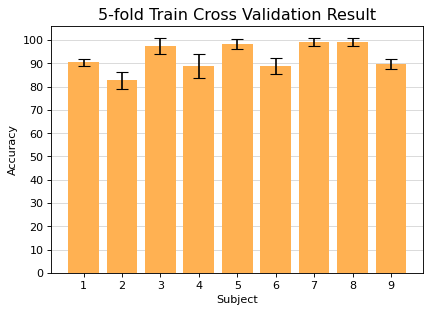

====== Accuracy for all subjects ======
Subject01 : 90.54 % +/- 1.52
Subject02 : 82.79 % +/- 3.70
Subject03 : 97.43 % +/- 3.46
Subject04 : 88.84 % +/- 5.05
Subject05 : 98.30 % +/- 2.09
Subject06 : 88.80 % +/- 3.43
Subject07 : 99.13 % +/- 1.74
Subject08 : 99.13 % +/- 1.74
Subject09 : 89.64 % +/- 2.19


In [52]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.grid(axis='y', alpha=0.5)
ax.bar(np.arange(1, ns), eval_acc, color="#ffb152", yerr=eval_std, capsize=5)
ax.set(xticks=np.arange(1, ns), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy',
       title='5-fold Train Cross Validation Result')
ax.set_axisbelow(True)
plt.savefig('5fold_train_result.jpg', bbox_inches='tight')
plt.show()

# Print each subject accuracy
print("====== Accuracy for all subjects ======")
for i in range(ns-1):
    print("Subject{:02d} : {:.2f} % +/- {:.2f}".format(i+1, eval_acc[i], eval_std[i]))

## Result on Test Data
Based on initial observation, svc model performed well on train data. Thus we will proceed to use the current model to evaluate on test data 

In [53]:
# Blank list to store accuracy values
train_score = []
test_score = []

for i in range(1, ns):
    subj = subject_counter(i)
    
    # Prepare train and test data
    data_train = mod_data[subj]['train']['mutual']
    X_train = data_train['X']
    y_train = data_train['y']
    
    data_test = mod_data[subj]['test']['mutual']
    X_test = data_train['X']
    y_test = data_train['y']
    
    # Training the model + train accuracy
    model.fit(X_train, y_train)
    tr_score = model.score(X_train, y_train)*100
    te_score = model.score(X_test, y_test)*100
    
    train_score.append(tr_score)
    test_score.append(te_score)

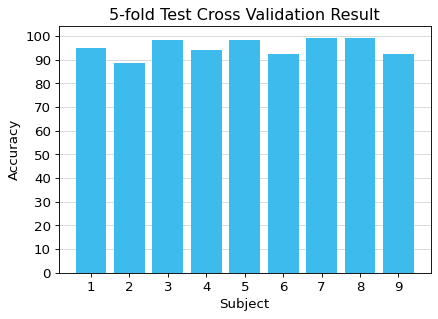

====== Test Accuracy for all subjects ======
Subject01 : 94.83 %
Subject02 : 88.79 %
Subject03 : 98.28 %
Subject04 : 93.97 %
Subject05 : 98.28 %
Subject06 : 92.24 %
Subject07 : 99.14 %
Subject08 : 99.14 %
Subject09 : 92.24 %


In [54]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.grid(axis='y', alpha=0.5)
ax.bar(np.arange(1, ns), test_score, color="#3ebbed")
ax.set(xticks=np.arange(1, ns), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy',
       title='5-fold Test Cross Validation Result')
ax.set_axisbelow(True)
plt.savefig('5fold_test_result.jpg', bbox_inches='tight')
plt.show()

# Print each subject accuracy
print("====== Test Accuracy for all subjects ======")
for i in range(ns-1):
    print("Subject{:02d} : {:.2f} %".format(i+1, test_score[i]))

In [61]:
print("Train Accuracy:",sum(eval_acc)/9)
print("Test Accuracy", sum(test_score)/9)

92.73349436392914
95.21072796934868


In [62]:
print(eval_acc)
print(test_score)

[np.float64(90.54347826086956), np.float64(82.78985507246377), np.float64(97.42753623188406), np.float64(88.84057971014492), np.float64(98.29710144927537), np.float64(88.80434782608695), np.float64(99.13043478260869), np.float64(99.13043478260869), np.float64(89.6376811594203)]
[94.82758620689656, 88.79310344827587, 98.27586206896551, 93.96551724137932, 98.27586206896551, 92.24137931034483, 99.13793103448276, 99.13793103448276, 92.24137931034483]
